In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery as bq

%matplotlib inline

In [4]:
probe = pd.read_table("./metadata/sig-DMD.union.includeERR.hm450probes", sep="\t", header=None)
probe.columns = ['chrom', 'start', 'end', 'probe_id', 
                 'UCSC.RefGene_Group', 'UCSC.RefGene_Accession', 'UCSC.RefGene_Name', 
                 'sig-DMD', 'DMV', 'pairs', 'no_pairs']

print(probe.shape)
probe.head()

(25329, 11)


,chrom,start,end,probe_id,UCSC.RefGene_Group,UCSC.RefGene_Accession,UCSC.RefGene_Name,sig-DMD,DMV,pairs,no_pairs
0,chr1,864878,864880,cg02896266,Body,NM_152486,SAMD11,sig-DMD_1,DMV_4,"nontrip_trip,normal_trip",2
1,chr1,931326,931328,cg03648020,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3
2,chr1,933305,933307,cg01729262,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3
3,chr1,933387,933389,cg15882305,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3
4,chr1,933684,933686,cg15713103,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3


In [38]:
pairs_splitted = probe['pairs'].str.split(",")
truefalse = [True if "ers_err" in l else False for l in indices]

probe_hormone = probe.loc[truefalse,:]
print(probe_hormone.shape)
probe_hormone.head()

(1727, 11)


,chrom,start,end,probe_id,UCSC.RefGene_Group,UCSC.RefGene_Accession,UCSC.RefGene_Name,sig-DMD,DMV,pairs,no_pairs
11,chr1,1286916,1286918,cg21679391,NaN,NaN,NaN,sig-DMD_4,DMV_9,"ers_err,normal_nontrip,normal_trip",3
12,chr1,1287258,1287260,cg21118819,NaN,NaN,NaN,sig-DMD_4,DMV_9,"ers_err,normal_nontrip,normal_trip",3
13,chr1,1288585,1288587,cg11414742,3'UTR,NM_032348,MXRA8,sig-DMD_4,DMV_9,"ers_err,normal_nontrip,normal_trip",3
14,chr1,1288925,1288927,cg15472728,3'UTR,NM_032348,MXRA8,sig-DMD_4,DMV_9,"ers_err,normal_nontrip,normal_trip",3
15,chr1,1289805,1289807,cg14270725,Body,NM_032348,MXRA8,sig-DMD_4,DMV_9,"ers_err,normal_nontrip,normal_trip",3


In [39]:
sample = pd.read_table("./metadata/hormone_metadata.tsv", sep="\t")

print(sample.shape)
sample.head()

(565, 7)


,case_barcode,sample_barcode,sample_type,sample_type_name,initial_response,recurrence_status,recurrence_log
0,TCGA-BH-A0C0,TCGA-BH-A0C0-01A,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
1,TCGA-BH-A0C0,TCGA-BH-A0C0-11A,11,Solid Tissue Normal,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
2,TCGA-D8-A141,TCGA-D8-A141-01A,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
3,TCGA-EW-A424,TCGA-EW-A424-01A,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
4,TCGA-AO-A12G,TCGA-AO-A12G-01A,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."


In [40]:
sample_barcodes = ", ".join("'%s'" % w for w in sample.sample_barcode)
probe_ids = ", ".join("'%s'" % w for w in probe_hormone.probe_id)

In [47]:
client = bq.Client()
methylation = 'isb-cgc.TCGA_hg19_data_v0.DNA_Methylation'

query="""\
SELECT 
    case_barcode, sample_barcode, aliquot_barcode, probe_id, beta_value
FROM
    `{}`
WHERE
    platform = "HumanMethylation450" AND
    sample_barcode IN ({}) AND probe_id IN ({})
""".format(methylation, sample_barcodes, probe_ids)

hormone_meth = client.query(query).to_dataframe()

print(hormone_meth.shape)

hormone_meth.head()

(667092, 5)


,case_barcode,sample_barcode,aliquot_barcode,probe_id,beta_value
0,TCGA-E9-A22B,TCGA-E9-A22B-01A,TCGA-E9-A22B-01A-11D-A161-05,cg22251148,0.91
1,TCGA-AC-A2FF,TCGA-AC-A2FF-01A,TCGA-AC-A2FF-01A-11D-A17F-05,cg00692780,0.86
2,TCGA-A2-A1FW,TCGA-A2-A1FW-01A,TCGA-A2-A1FW-01A-11D-A13K-05,cg13217260,0.85
3,TCGA-A2-A0CT,TCGA-A2-A0CT-01A,TCGA-A2-A0CT-01A-31D-A10P-05,cg16964348,0.93
4,TCGA-S3-AA11,TCGA-S3-AA11-01A,TCGA-S3-AA11-01A-31D-A41Q-05,cg26708220,0.88


In [70]:
hormone_meth_bigtable = pd.merge(hormone_meth, sample, how='inner', on=["sample_barcode", "case_barcode"])

print(hormone_meth_bigtable.shape)
hormone_meth_bigtable.head()

(667092, 10)


,case_barcode,sample_barcode,aliquot_barcode,probe_id,beta_value,sample_type,sample_type_name,initial_response,recurrence_status,recurrence_log
0,TCGA-E9-A22B,TCGA-E9-A22B-01A,TCGA-E9-A22B-01A-11D-A161-05,cg22251148,0.91,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
1,TCGA-E9-A22B,TCGA-E9-A22B-01A,TCGA-E9-A22B-01A-11D-A161-05,cg06830064,0.94,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
2,TCGA-E9-A22B,TCGA-E9-A22B-01A,TCGA-E9-A22B-01A-11D-A161-05,cg16786808,0.88,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
3,TCGA-E9-A22B,TCGA-E9-A22B-01A,TCGA-E9-A22B-01A-11D-A161-05,cg05490308,0.86,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."
4,TCGA-E9-A22B,TCGA-E9-A22B-01A,TCGA-E9-A22B-01A-11D-A161-05,cg04515533,0.93,1,Primary solid Tumor,Unknown,Unknown,"Alive tumor free, last follow-up within risky ..."


In [71]:
hormone_meth_bigtable.to_csv("./datasets/hormone_meth_bigtable.HM450.tsv", sep="\t", index=False)

In [61]:
matrix = hormone_meth_bigtable.pivot(index='probe_id', columns='aliquot_barcode', values='beta_value')

print(matrix.shape)
matrix.head()

(1605, 416)


aliquot_barcode,TCGA-5L-AAT0-01A-12D-A41Q-05,TCGA-5L-AAT1-01A-12D-A41Q-05,TCGA-5T-A9QA-01A-11D-A41Q-05,TCGA-A1-A0SF-01A-11D-A145-05,TCGA-A1-A0SQ-01A-21D-A145-05,TCGA-A2-A04R-01A-41D-A10A-05,TCGA-A2-A0CK-01A-11D-A22B-05,TCGA-A2-A0CO-01A-13D-A22B-05,TCGA-A2-A0CR-01A-11D-A22B-05,TCGA-A2-A0CT-01A-31D-A10P-05,...,TCGA-S3-A6ZG-01A-22D-A32T-05,TCGA-S3-A6ZH-01A-22D-A32T-05,TCGA-S3-AA11-01A-31D-A41Q-05,TCGA-S3-AA12-01A-11D-A41Q-05,TCGA-S3-AA17-01A-11D-A41Q-05,TCGA-V7-A7HQ-01A-11D-A33F-05,TCGA-W8-A86G-01A-21D-A36K-05,TCGA-WT-AB41-01A-11D-A41Q-05,TCGA-WT-AB44-01A-11D-A41Q-05,TCGA-XX-A899-01A-11D-A36K-05
probe_id,,,,,,,,,,,,,,,,,,,,,
cg00000321,0.59,0.40,0.78,0.26,0.12,0.07,0.45,0.31,0.32,0.76,...,0.65,0.28,0.65,0.10,0.57,0.50,0.47,0.65,0.66,0.54
cg00008036,0.25,0.42,0.60,0.14,0.10,0.62,0.35,0.28,0.26,0.35,...,0.31,0.21,0.52,0.19,0.48,0.11,0.22,0.25,0.47,0.16
cg00024494,0.83,0.59,0.93,0.70,0.90,0.94,0.76,0.44,0.54,0.94,...,0.60,0.90,0.91,0.94,0.58,0.90,0.89,0.72,0.90,0.66
cg00035316,0.56,0.47,0.87,0.54,0.78,0.65,0.71,0.69,0.40,0.82,...,0.64,0.59,0.78,0.44,0.45,0.27,0.61,0.62,0.56,0.53
cg00040588,0.33,0.33,0.84,0.30,0.57,0.74,0.30,0.57,0.36,0.53,...,0.71,0.67,0.50,0.65,0.34,0.25,0.59,0.51,0.28,0.34


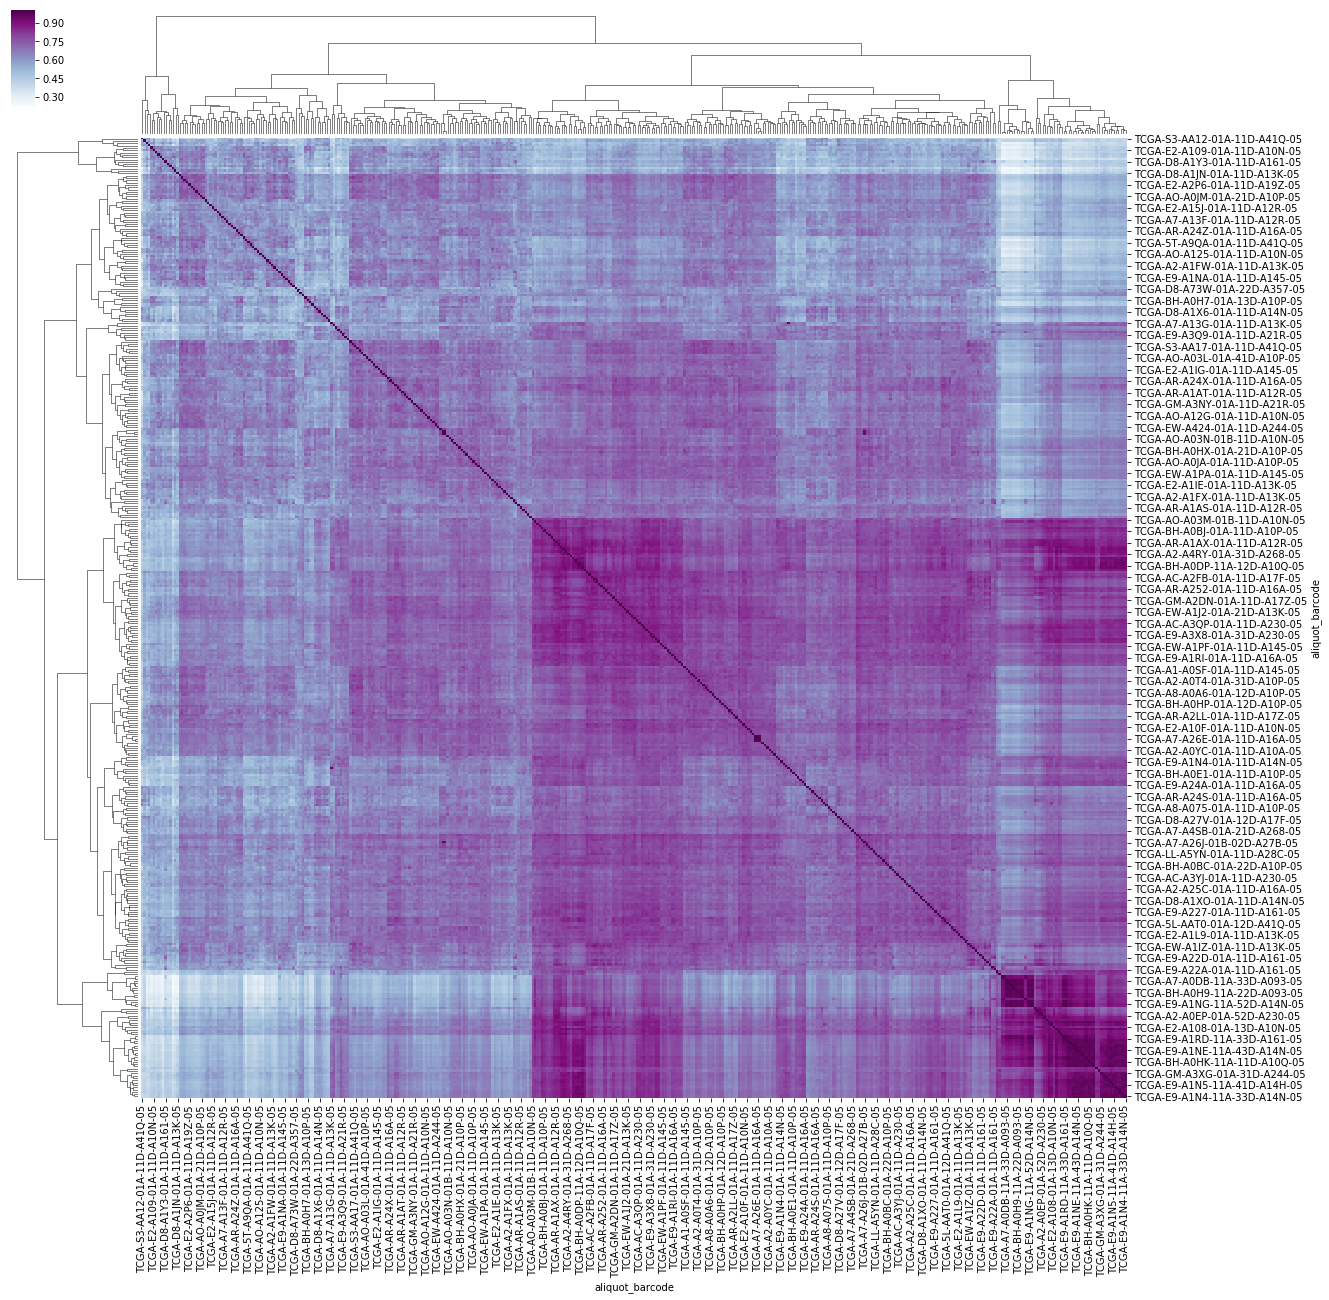

In [69]:
sns.clustermap(data=matrix.corr(), method='complete', cmap="BuPu", figsize=(20,20))